In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [5]:
cols = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


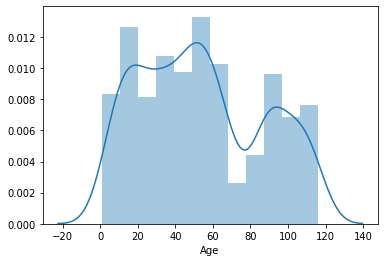

PropertyGFATotal
19.037917545145827


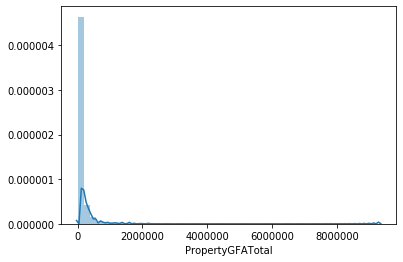

LargestPropertyUseTypeGFA
23.175161728669494


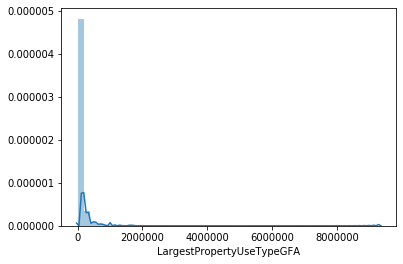

ENERGYSTARScore
-0.7541760590305383


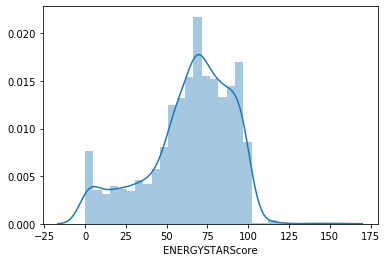

TotalGHGEmissions
14.130719705301496


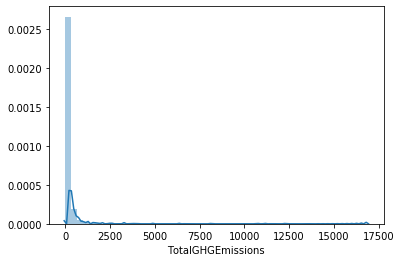

In [6]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [7]:
cols = ['PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

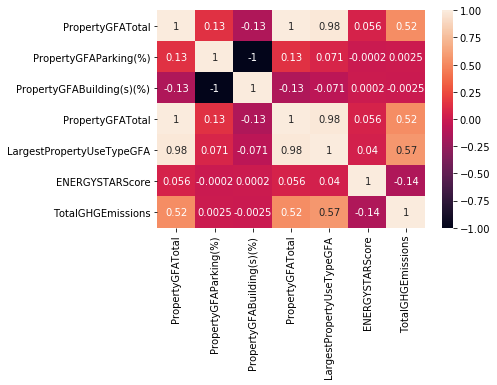

In [8]:
sns.heatmap(data[cols].corr(), annot = True)

In [10]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','ENERGYSTARNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
colsk = ['NumberofFloors','PropertyGFATotal','LargestPropertyUseTypeGFA']

In [13]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [14]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [15]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [16]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5688394169415

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

605.2274428419815

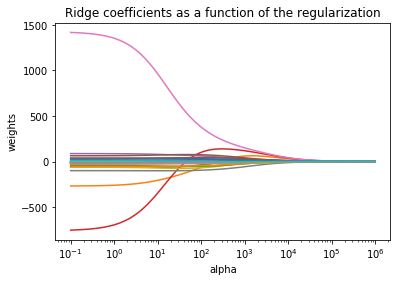

In [18]:
n_alphas = 100
alphas = np.logspace(-1, 6, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

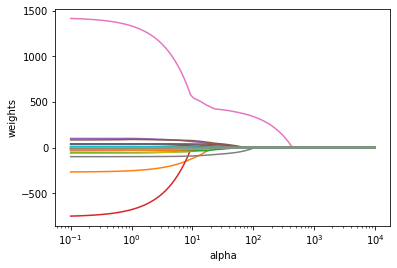

In [19]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [20]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_fit_time', 'mean_test_RMSE', 
    'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 
    'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [21]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [23]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},0.001170,470.065413,1,385569.002584,1,155.745895,1,0.186252,2
7,{'alpha': 379.26901907322497},0.001158,499.494432,2,398791.601142,2,169.782026,3,0.091619,4
9,{'alpha': 2069.138081114788},0.000927,511.792190,3,424601.980468,3,162.471514,2,0.193181,1
10,{'alpha': 4832.930238571752},0.000993,551.372233,4,474882.808559,4,178.949808,4,0.133610,3
6,{'alpha': 162.3776739188721},0.001031,563.782284,5,501007.570428,5,187.820559,5,-0.098578,8


In [24]:
grid_ridge_best_params ={'alpha': 885.8667904100823}

In [25]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

665.4599560559155

In [26]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
22,{'alpha': 108.2636733874054},0.001140,482.028960,1,390669.051705,2,166.475130,4,0.161623,2
21,{'alpha': 78.80462815669912},0.001099,485.665692,2,388005.410740,1,160.865919,2,0.166664,1
20,{'alpha': 57.361525104486816},0.001180,510.357643,3,408180.264031,3,159.359752,1,0.134961,4
23,{'alpha': 148.73521072935117},0.001290,519.455393,4,423479.225801,4,174.166181,6,0.142763,3
19,{'alpha': 41.753189365604},0.000983,549.135944,5,473366.481010,5,164.444362,3,0.057041,6


In [27]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [28]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1877988517828

In [29]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

"tt_ridge = TransformedTargetRegressor(regressor = Ridge(),\n                               func = np.log1p,\n                               inverse_func = np.expm1)\nparams = {'regressor__alpha': np.logspace(0, 7, 100)}\ngrid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)\ngrid_tt_ridge.fit(X_train_tt, y_train)\ngrid_tt_ridge_best_params = grid_tt_ridge.best_params_\nresultize(grid_tt_ridge).head()"

In [30]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [31]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

675.0517088164155

In [32]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
1,{'regressor__alpha': 0.1373823795883263},0.001354,488.604952,1,420601.605659,1,126.595569,1,0.304160,2
0,{'regressor__alpha': 0.1},0.001556,509.851493,2,430242.550446,2,126.993029,2,0.314102,1
2,{'regressor__alpha': 0.18873918221350972},0.001366,525.030041,3,449584.447178,3,134.174582,3,0.242027,3
3,{'regressor__alpha': 0.2592943797404667},0.001465,567.893499,4,500133.461503,4,141.624215,4,0.155992,4
4,{'regressor__alpha': 0.3562247890262442},0.001316,595.496980,5,541587.619100,5,147.306848,5,0.082783,5


In [33]:
grid_tt_lasso_best_params = {'alpha':0.1373823795883263}

In [34]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

704.4596002538576

In [35]:
"""params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()"""

"params = {'kernel': ['sigmoid','rbf','poly'],\n         'C': [0.1,1,100,1000],\n         'degree': [1,2,3,4,5,6]}\ngrid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,\n                        refit = score,  n_jobs=-1)\ngrid_svr.fit(X_train, y_train)\nbest_params_svr = grid_svr.best_params_\nresultize(grid_svr).head()"

In [36]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [37]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

681.4145543613745

In [38]:
"""tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()"""

"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6]}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train_tt, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [39]:
best_params_svr_tt = {'C': 1, 'degree': 6}

In [40]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

514.2155879409045

In [41]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'max_depth': [1,3,5,7,9],\n            'min_samples_split': [3,5,7,9],\n}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [42]:
best_params_rf = {'max_depth': 9, 'min_samples_split': 9, 'n_estimators': 100}

In [45]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

352.3463483193694

In [46]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

"tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__max_depth': [1,3,5,7,9],\n            'regressor__min_samples_split': [3,5,7,9]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train_tt, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [47]:
best_params_rf_tt = {'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200}

In [48]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

382.7109605590143

In [49]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [50]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 5}

In [51]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

418.7625701261802

In [52]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

"tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [53]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [54]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

195.01342305859515

In [55]:
'''params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'loss': ['linear', 'square', 'exponential'],\n}\ngrid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_ad.fit(X_train, y_train)\nbest_params_ad = grid_ad.best_params_\nresultize(grid_ad).head()"

In [56]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [57]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

353.879274469603

In [58]:
'''tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

"tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train_tt, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [59]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'linear',
      'n_estimators': 200
      }

In [60]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

564.595615089367

In [61]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

"params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [62]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [63]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

665.7410079239659

In [64]:
'''tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()'''
#1m20s

"tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_tt_mlp = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [65]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [66]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

549.031070399817

In [67]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [68]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [69]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

280.2255988112745

In [70]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

"tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt, y_train)\nbest_params_tt_xgb = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [71]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [72]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

217.3290369369139

In [73]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [74]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
11,Gradient Boosting_tt,195.013423
17,XGBoost_tt,217.329037
16,XGBoost,280.225599
8,Random Forest,352.346348
12,AdaBoost,353.879274
9,Random Forest_tt,382.710961
10,Gradient Boosting,418.762570
7,SVR_tt,514.215588
15,MLP_tt,549.031070
13,AdaBoost_tt,564.595615


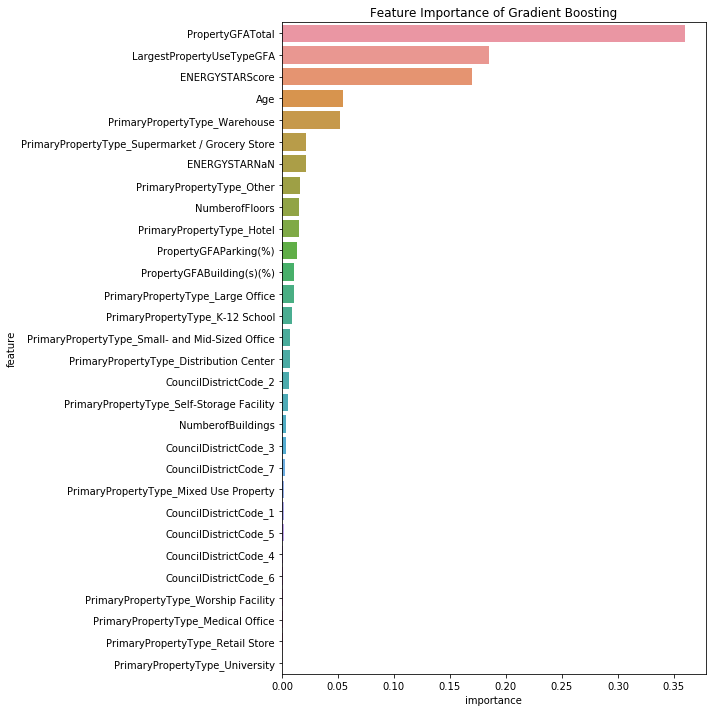

In [75]:
#feature importance of gradient boosting tt
feat_imp_gb_tt = pd.DataFrame({'importance': gb_tt.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_gb_tt)
plt.title('Feature Importance of Gradient Boosting')
plt.tight_layout()
plt.show()

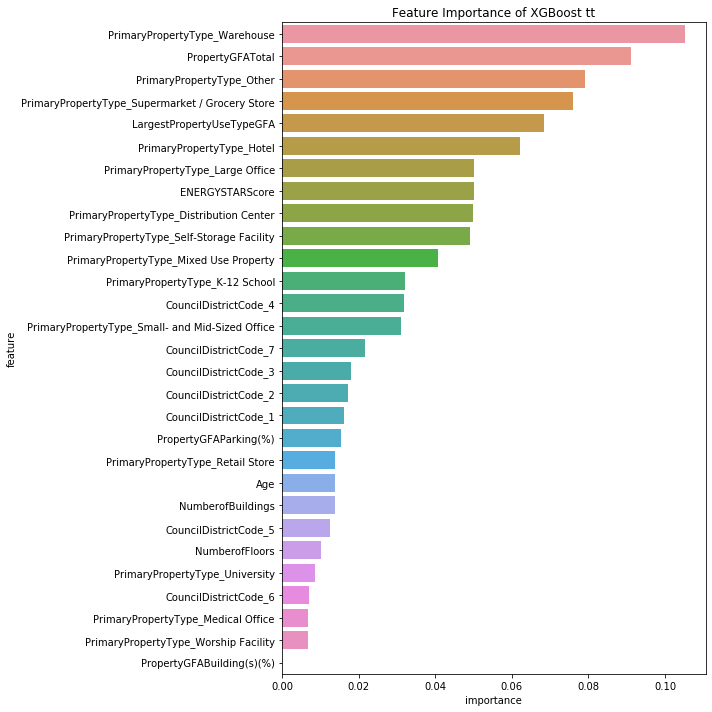

In [89]:
#feature importance of xgboost tt
feat_imp_xgb_tt = pd.DataFrame({'importance': tt_xgb.regressor_.feature_importances_})
feat_imp_xgb_tt['feature'] = X_train.columns
feat_imp_xgb_tt = feat_imp_xgb_tt.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_xgb_tt)
plt.title('Feature Importance of XGBoost tt')
plt.tight_layout()
plt.show()

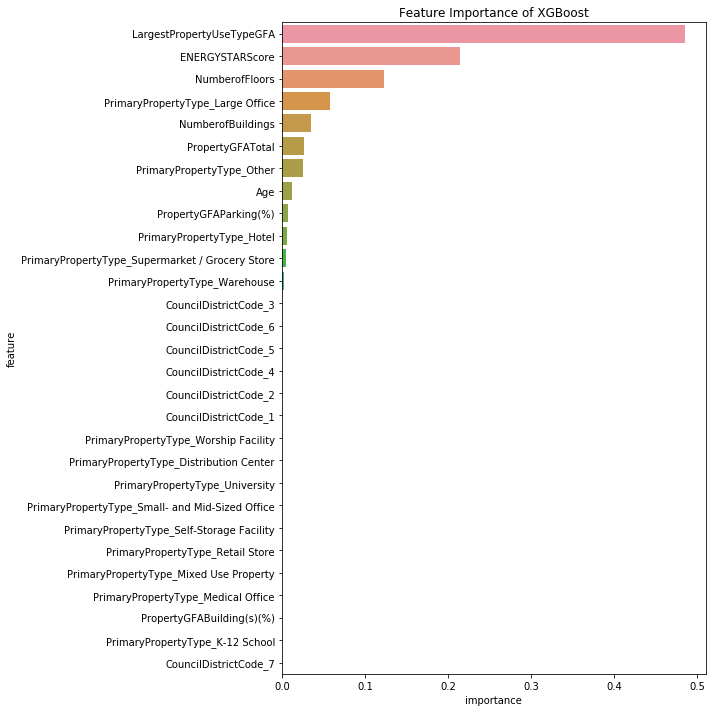

In [88]:
#feature importance of xgboost
feat_imp_xgb = pd.DataFrame({'importance': xgb.feature_importances_})
feat_imp_xgb['feature'] = X_train.columns
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_xgb)
plt.title('Feature Importance of XGBoost')
plt.tight_layout()
plt.show()

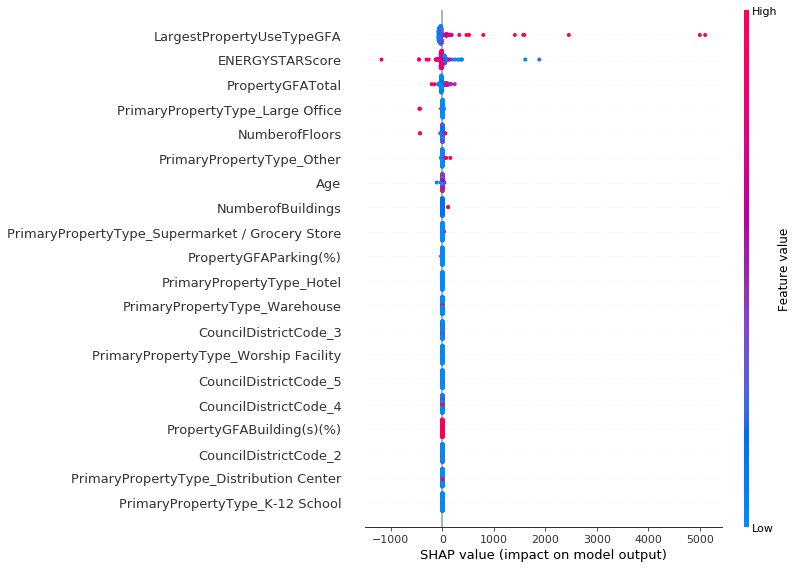

In [76]:
explainer = shap.TreeExplainer(xgb, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test)

In [77]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,PropertyGFATotal,0.398407
7,ENERGYSTARScore,0.173125
6,LargestPropertyUseTypeGFA,0.146782
0,Age,0.042590
18,PrimaryPropertyType_Supermarket / Grocery Store,0.041834
14,PrimaryPropertyType_Other,0.039582
2,NumberofFloors,0.027899
11,PrimaryPropertyType_Large Office,0.024143
20,PrimaryPropertyType_Warehouse,0.021775
4,PropertyGFAParking(%),0.019864


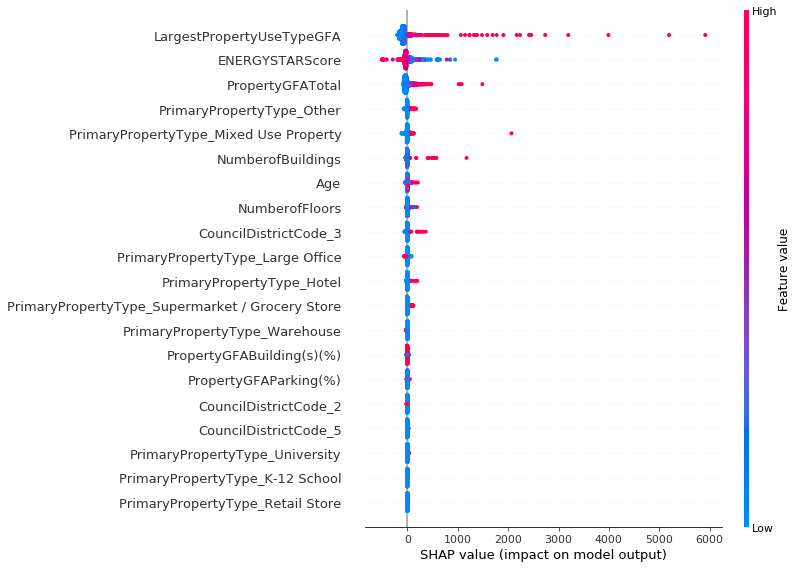

In [78]:
explainer = shap.TreeExplainer(rf)
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

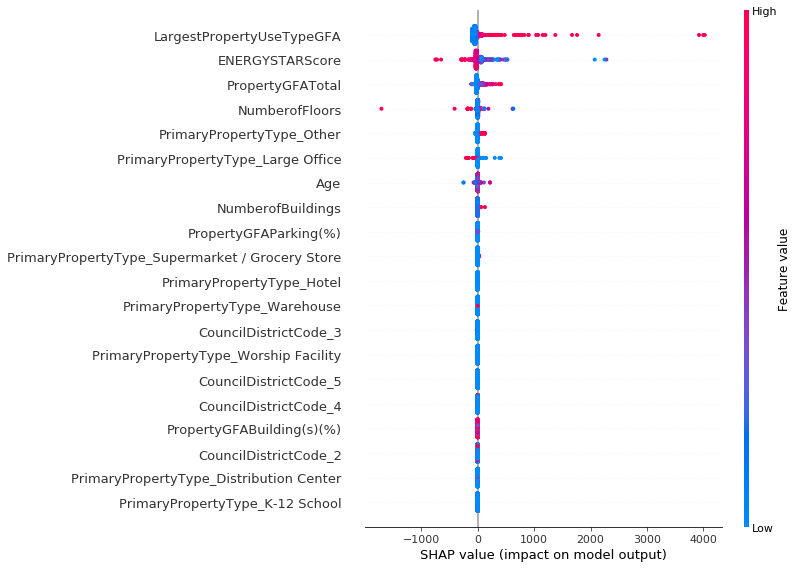

In [79]:
explainer = shap.TreeExplainer(xgb)
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [80]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
i=0
shap.force_plot(explainer.expected_value, shap_values[i], 
                X_train.values[i], feature_names=X_train.columns)

In [82]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap.force_plot(explainer.expected_value, shap_values, 
                X_train.values, feature_names=X_train.columns)

In [93]:
X_train_tt_drop_ESS = X_train_tt.drop(labels = X_train_tt.loc[X_train_tt['ENERGYSTARNaN']==0].index, axis = 0)
X_test_tt_drop_ESS = X_test_tt.drop(labels = X_test_tt.loc[X_test_tt['ENERGYSTARNaN']==0].index, axis = 0)

In [78]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt_drop_ESS, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
9,"{'regressor__learning_rate': 0.05, 'regressor_...",13.642042,375.736977,1,274589.631751,1,95.033031,1,0.538312,4
8,"{'regressor__learning_rate': 0.05, 'regressor_...",10.198304,380.804942,2,278859.603538,2,96.656425,2,0.529773,6
14,"{'regressor__learning_rate': 0.05, 'regressor_...",18.257533,386.411013,3,281638.013195,3,96.775534,3,0.554584,1
7,"{'regressor__learning_rate': 0.05, 'regressor_...",8.047787,390.617460,4,287608.132970,5,98.980722,6,0.544965,2
13,"{'regressor__learning_rate': 0.05, 'regressor_...",14.276628,390.958735,5,286631.699904,4,97.107985,4,0.544489,3


In [96]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

In [97]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt_drop_ESS, y_train)
y_pred = tt_xgb.predict(X_test_tt_drop_ESS)
tt_xgb_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error_ESS

240.07524447239513

In [98]:
tt_xgb_error 

217.3290369369139